In [1]:
import numpy as np
import pandas as pd
import warnings
import random
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
file = 'C:\\Users\\test\\Documents\\Codes\\Python\\Personnel\\NASA-hackathon-2024\\data_SEDAC.csv'
df = pd.read_csv(file, encoding='ISO-8859-1')
index = ['BIOTECH', 'HAZWST','BLDTOT', 'PTETHR', 'FLPTHR', 'SPPASS', 'AMTHR','SPPTOT']

In [3]:
df_pivot = df.pivot_table(index=None, 
                          columns='Country_Standard', 
                          values=index,
                          aggfunc='first')  # Use 'first' to take the first value in case of duplicates

df_pivot = df_pivot.replace(" ", 0, regex=True)
data_brut = df_pivot.to_numpy()

In [4]:
country_to_region = {
    'Afghanistan': 'Asia',
    'Albania': 'Europe',
    'Algeria': 'Africa',
    'American Samoa': 'Oceania',
    'Andorra': 'Europe',
    'Angola': 'Africa',
    'Anguilla': 'America',
    'Antarctica': 'Antarctica',
    'Antigua and Barbuda': 'America',
    'Argentina': 'America',
    'Armenia': 'Asia',
    'Aruba': 'America',
    'Australia': 'Oceania',
    'Austria': 'Europe',
    'Azerbaijan': 'Asia',
    'Bahamas': 'America',
    'Bahrain': 'Asia',
    'Bangladesh': 'Asia',
    'Barbados': 'America',
    'Belarus': 'Europe',
    'Belgium': 'Europe',
    'Belize': 'America',
    'Benin': 'Africa',
    'Bermuda': 'America',
    'Bhutan': 'Asia',
    'Bolivia': 'America',
    'Bosnia and Herzegovina': 'Europe',
    'Botswana': 'Africa',
    'Bouvet Island': 'Antarctica',
    'Brazil': 'America',
    'British Indian Ocean Territory': 'Asia',
    'British Virgin Islands': 'America',
    'Brunei Darussalam': 'Asia',
    'Bulgaria': 'Europe',
    'Burkina Faso': 'Africa',
    'Burundi': 'Africa',
    'Cambodia': 'Asia',
    'Cameroon': 'Africa',
    'Canada': 'America',
    'Cape Verde': 'Africa',
    'Cayman Islands': 'America',
    'Central African Republic': 'Africa',
    'Chad': 'Africa',
    'Chile': 'America',
    'China': 'Asia',
    'Christmas Island': 'Asia',
    'Cocos (Keeling) Islands': 'Asia',
    'Colombia': 'America',
    'Comoros': 'Africa',
    'Congo': 'Africa',
    'Cook Islands': 'Oceania',
    'Costa Rica': 'America',
    'Croatia': 'Europe',
    'Cuba': 'America',
    'Cyprus': 'Asia',
    'Czech Republic': 'Europe',
    "Côte d'Ivoire": 'Africa',
    "Democratic People's Republic of Korea": 'Asia',
    'Democratic Republic of the Congo': 'Africa',
    'Denmark': 'Europe',
    'Djibouti': 'Africa',
    'Dominica': 'America',
    'Dominican Republic': 'America',
    'Ecuador': 'America',
    'Egypt': 'Africa',
    'El Salvador': 'America',
    'Equatorial Guinea': 'Africa',
    'Eritrea': 'Africa',
    'Estonia': 'Europe',
    'Ethiopia': 'Africa',
    'Faeroe Islands': 'Europe',
    'Falkland Islands (Malvinas)': 'America',
    'Fiji': 'Oceania',
    'Finland': 'Europe',
    'France': 'Europe',
    'French Guiana': 'America',
    'French Polynesia': 'Oceania',
    'Gabon': 'Africa',
    'Gambia': 'Africa',
    'Georgia': 'Asia',
    'Germany': 'Europe',
    'Ghana': 'Africa',
    'Gibraltar': 'Europe',
    'Greece': 'Europe',
    'Greenland': 'Europe',
    'Grenada': 'America',
    'Guadeloupe': 'America',
    'Guam': 'Oceania',
    'Guatemala': 'America',
    'Guinea': 'Africa',
    'Guinea-Bissau': 'Africa',
    'Guyana': 'America',
    'Haiti': 'America',
    'Heard Island and McDonald Islands': 'Antarctica',
    'Holy See': 'Europe',
    'Honduras': 'America',
    'Hong Kong Special Administrative Region of China': 'Asia',
    'Hungary': 'Europe',
    'Iceland': 'Europe',
    'India': 'Asia',
    'Indonesia': 'Asia',
    'Iran (Islamic Republic of)': 'Asia',
    'Iraq': 'Asia',
    'Ireland': 'Europe',
    'Israel': 'Asia',
    'Italy': 'Europe',
    'Jamaica': 'America',
    'Japan': 'Asia',
    'Jordan': 'Asia',
    'Kazakhstan': 'Asia',
    'Kenya': 'Africa',
    'Kiribati': 'Oceania',
    'Kuwait': 'Asia',
    'Kyrgyzstan': 'Asia',
    "Lao People's Democratic Republic": 'Asia',
    'Latvia': 'Europe',
    'Lebanon': 'Asia',
    'Lesotho': 'Africa',
    'Liberia': 'Africa',
    'Libyan Arab Jamahiriya': 'Africa',
    'Liechtenstein': 'Europe',
    'Lithuania': 'Europe',
    'Luxembourg': 'Europe',
    'Macao Special Administrative Region of China': 'Asia',
    'Macedonia': 'Europe',
    'Madagascar': 'Africa',
    'Malawi': 'Africa',
    'Malaysia': 'Asia',
    'Maldives': 'Asia',
    'Mali': 'Africa',
    'Malta': 'Europe',
    'Marshall Islands': 'Oceania',
    'Martinique': 'America',
    'Mauritania': 'Africa',
    'Mauritius': 'Africa',
    'Mayotte': 'Africa',
    'Mexico': 'America',
    'Micronesia (Federated States of)': 'Oceania',
    'Monaco': 'Europe',
    'Mongolia': 'Asia',
    'Montserrat': 'America',
    'Morocco': 'Africa',
    'Mozambique': 'Africa',
    'Myanmar': 'Asia',
    'Namibia': 'Africa',
    'Nauru': 'Oceania',
    'Nepal': 'Asia',
    'Netherlands': 'Europe',
    'Netherlands Antilles': 'America',
    'New Caledonia': 'Oceania',
    'New Zealand': 'Oceania',
    'Nicaragua': 'America',
    'Niger': 'Africa',
    'Nigeria': 'Africa',
    'Niue': 'Oceania',
    'Norfolk Island': 'Oceania',
    'Northern Mariana Islands': 'Oceania',
    'Norway': 'Europe',
    'Occupied Palestinian Territory': 'Asia',
    'Oman': 'Asia',
    'Pakistan': 'Asia',
    'Palau': 'Oceania',
    'Panama': 'America',
    'Papua New Guinea': 'Oceania',
    'Paraguay': 'America',
    'Peru': 'America',
    'Philippines': 'Asia',
    'Pitcairn': 'Oceania',
    'Poland': 'Europe',
    'Portugal': 'Europe',
    'Puerto Rico': 'America',
    'Qatar': 'Asia',
    'Republic of Korea': 'Asia',
    'Republic of Moldova': 'Europe',
    'Romania': 'Europe',
    'Russian Federation': 'Asia',
    'Rwanda': 'Africa',
    'Réunion': 'Africa',
    'Saint Helena': 'Africa',
    'Saint Kitts and Nevis': 'America',
    'Saint Lucia': 'America',
    'Saint Pierre and Miquelon': 'America',
    'Saint Vincent and the Grenadines': 'America',
    'Samoa': 'Oceania',
    'San Marino': 'Europe',
    'Sao Tome and Principe': 'Africa',
    'Saudi Arabia': 'Asia',
    'Senegal': 'Africa',
    'Serbia and Montenegro': 'Europe',
    'Seychelles': 'Africa',
    'Sierra Leone': 'Africa',
    'Singapore': 'Asia',
    'Slovakia': 'Europe',
    'Slovenia': 'Europe',
    'Solomon Islands': 'Oceania',
    'Somalia': 'Africa',
    'South Africa': 'Africa',
    'South Georgia and the Islands': 'America',
    'Spain': 'Europe',
    'Sri Lanka': 'Asia',
    'Sudan': 'Africa',
    'Suriname': 'America',
    'Svalbard and Jan Mayen Islands': 'Europe',
    'Swaziland': 'Africa',
    'Sweden': 'Europe',
    'Switzerland': 'Europe',
    'Syrian Arab Republic': 'Asia',
    'Taiwan': 'Asia',
    'Tajikistan': 'Asia',
    'Thailand': 'Asia',
    'Timor-Leste': 'Asia',
    'Togo': 'Africa',
    'Tokelau': 'Oceania',
    'Tonga': 'Oceania',
    'Trinidad and Tobago': 'America',
    'Tunisia': 'Africa',
    'Turkey': 'Asia',
    'Turkmenistan': 'Asia',
    'Turks and Caicos Islands': 'America',
    'Tuvalu': 'Oceania',
    'Uganda': 'Africa',
    'Ukraine': 'Europe',
    'United Arab Emirates': 'Asia',
    'United Kingdom of Great Britain and Northern Ireland': 'Europe',
    'United Republic of Tanzania': 'Africa',
    'United States Minor Outlying Islands': 'Oceania',
    'United States Virgin Islands': 'America',
    'United States of America': 'America',
    'Uruguay': 'America',
    'Uzbekistan': 'Asia',
    'Vanuatu': 'Oceania',
    'Venezuela': 'America',
    'Viet Nam': 'Asia',
    'Wallis and Futuna Islands': 'Oceania',
    'Western Sahara': 'Africa',
    'Yemen': 'Asia',
    'Zambia': 'Africa',
    'Zimbabwe': 'Africa'
}


In [5]:
df_pivot.columns = df_pivot.columns.map(country_to_region)

In [6]:
labels_columns = df_pivot.columns.to_numpy()
labels_row = df_pivot.index.to_numpy()
R = df_pivot.to_numpy().astype("float").T

Lets first define all basic mathematic definition 

In [7]:
def Esperance(X):  # Calcul l'Esperance de X
    m = np.shape(X)[0]
    return(np.sum(X)/m)

def Variance(X):  # Calcul la Variance de X
    m = np.shape(X)[0]
    return(np.sum(((X-Esperance(X))**2)/(m-1)))

def centre_red(R):  # Calcul de la matrice centrée réduite de R
    m, n = np.shape(R)  # shape de la matrice d'entrée
    Rcr = np.zeros((m, n))  # matrice de zéros de taille (m,n)
    for i in range(n):
        Xa = R[:, i]  # Récupère la colonne de R
        # calcul de chaque colonne de la futur matrice centrée réduite
        Rcr[:, i] = (Xa-Esperance(Xa)) / np.sqrt(Variance(Xa))
    return (Rcr)

def approx(R, k):  # Calcul l'Esperance
    X = centre_red(R)  # On centre réduit notre matrice d'entrée
    m, n = np.shape(X)  # on stock la forme m,n de la matrice centrée reduite
    u, s, vt = np.linalg.svd(X)
    v = vt.T  # transpose vt
    projk = []
    for i in range(k):
        vk = v[:, i].reshape(len(v), 1)  # on récupère vk la colonne i de v
        Yk = X@vk  # on calcul Yk avec X et vk
        uj = u[:, i].reshape(len(u), 1)  # on récupère uj la colonne i de u
        # on insert dans projk la variance de Yk*uj
        projk.insert(i, Variance(Yk)*uj)
    # on utilise np.block pour construire notre matrice finale projk
    projk = np.block([projk[i] for i in range(k)])
    return(projk)


def Covariance(X, Y):  # Calcul de la Covariance de X avec Y
    m = np.shape(X)[0]
    return(np.sum((X-Esperance(X))*(Y-Esperance(Y)))*(1/m))

def correlation(X, Y):  # Fonction de Corélation entre deux matrices de même taille
    Cori = []
    m, n = np.shape(X)  # on stock la forme m,n de la matrice centrée reduite X
    for i in range(n):
        # Calcul de la corélation entre Y1 et Xi avec i variant de 0 à n-1
        Corik = Covariance(X[:, i], Y) / (Variance(X[:, i])*Variance(Y)) ** 0.5
        Cori.insert(i, Corik)  # on stock le résultat
    # la fonction est déjà en transposée
    return(Cori)

def correlationdirprinc(R, k):  # Ensemble des corélation de Yk et Xi
    X = centre_red(R)
    Y = approx(X, k)
    Cori = []
    for i in range(k):
        # on applique la fonction Cori sur X et la colonne i de Y
        Corik = correlation(X, Y[:, i])
        Cori.insert(i, Corik)  # On stock le résultat final
    return (Cori)

In [22]:
def PCA2D(R, labels_row, labels_columns):
    X = centre_red(R)
    u, s, vt = np.linalg.svd(X)
    
    m, k = X.shape
    explained_variance = (s**2) / np.sum(s**2)  # Calculate explained variance
    
    ind = [f'$Y_{i+1}$' for i in range(k)]  # Principal component labels
    
    # Bar chart for explained variance
    plt.figure()
    plt.bar(ind, explained_variance, width=0.8, color='royalblue')
    plt.xlabel('Principal Components', fontsize=9)
    plt.ylabel('Explained Variance', fontsize=9)
    plt.title(f'Variance of Each Component')
    
    for i, value in enumerate(explained_variance):
        plt.text(i-0.1, value+0.01, str(round(value, 6)))  # Annotate bars
    plt.show()
    
    # Pie chart for variance contribution
    plt.figure()
    plt.pie(explained_variance, labels=ind, autopct='%.1f%%', shadow=True)
    plt.title('Contribution to Total Variance')
    plt.show()
    
    Corx = correlationdirprinc(R, 2)[0]
    Cory = correlationdirprinc(R, 2)[1]
    # Tracé des flèches et de leur label
    fig, ax = plt.subplots()
    plt.grid()
    plt.title('Circle of corelation')
    plt.xlabel('$Y_{1}$')
    plt.ylabel('$Y_{2}$')
    draw_circle = plt.Circle((0.0, 0.0), 1.0, fill=False, ls='--', color='royalblue')
    plt.xlim(-1.2,1.2)
    plt.ylim(-1.2,1.2)
    ax.add_artist(draw_circle)
    ax.set_aspect(1)
    for i in range(np.shape(R)[1]):
        plt.arrow(0, 0, Corx[i], Cory[i], width=0.02,
                  length_includes_head=True, color='royalblue')
        plt.annotate(text=labels_row[i], xy=(
            Corx[i], Cory[i]),  fontsize=12)

    plt.show()
    
    
    # Approximation des données à 2 dimensions en utilisant vos fonctions
    Y = approx(X, 2)
    # Encoder les labels en numéros si ce sont des catégories textuelles
    label_encoder = LabelEncoder()
    labels_encoded = label_encoder.fit_transform(labels_columns)
    # Tracé des données projetées dans l'espace des composantes principales
    plt.figure()
    scatter = plt.scatter(Y[:, 0], Y[:, 1], c=labels_encoded, cmap='viridis', alpha=0.7)
    # Annoter le graphique avec des axes, une légende, et un titre
    plt.xlabel('Composante Principale 1 ($Y_1$)')
    plt.ylabel('Composante Principale 2 ($Y_2$)')
    plt.title('Projection des données sur les deux premières composantes principales')
    plt.grid(True)
    cbar = plt.colorbar(scatter)
    cbar.set_ticks(np.arange(len(label_encoder.classes_)))
    cbar.set_ticklabels(label_encoder.classes_)  # Afficher les labels originaux dans la barre de couleur
    plt.show()
    
    Y = approx(X, 3)
    
    # Encoder les labels en numéros si ce sont des catégories textuelles
    label_encoder = LabelEncoder()
    labels_encoded = label_encoder.fit_transform(labels_columns)
    
    # Tracé en 3D des données projetées dans l'espace des composantes principales
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    #jitter_strength = 0.02  # Force du bruit aléatoire
    #Y = Y + np.random.normal(scale=jitter_strength, size=Y.shape)

    scatter = ax.scatter(Y[:, 0], Y[:, 1], Y[:, 2], c=labels_encoded, cmap='viridis', alpha=0.7)
    
    # Annoter le graphique avec des axes, une légende, et un titre
    ax.set_xlabel('$Y_1$')
    ax.set_ylabel('$Y_2$')
    ax.set_zlabel('$Y_3$')
    ax.set_title('Projection on the best three principal components')
    
    # Ajouter une barre de couleurs pour montrer les labels encodés
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_ticks(np.arange(len(label_encoder.classes_)))
    cbar.set_ticklabels(label_encoder.classes_)  # Afficher les labels originaux dans la barre de couleur
    
    plt.show()
        

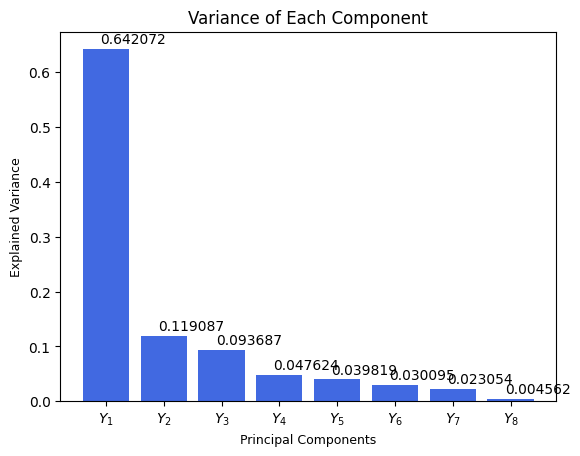

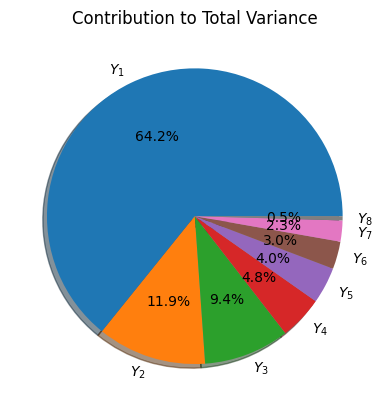

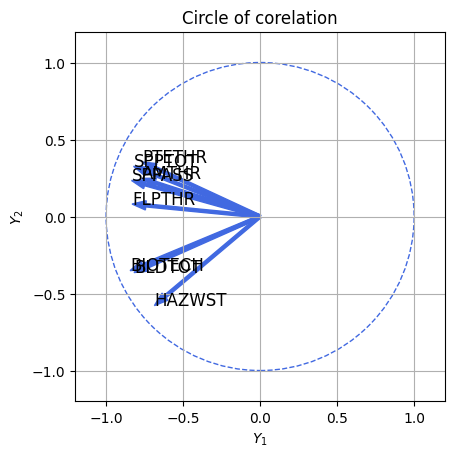

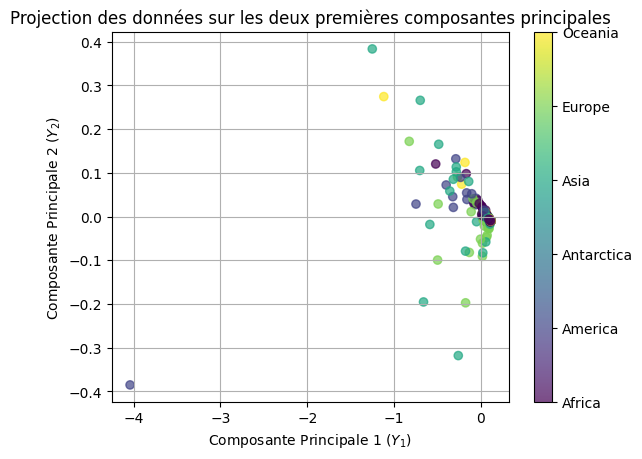

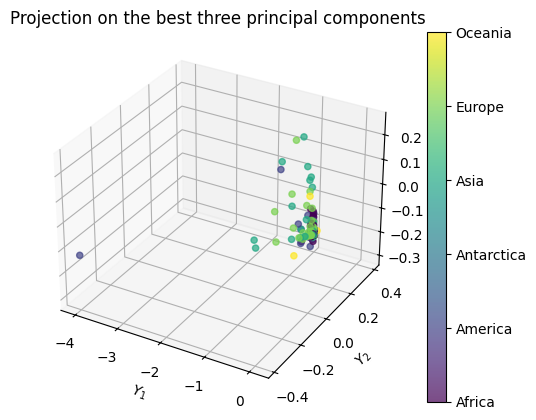

In [23]:
PCA2D(R, labels_row, labels_columns)

In [24]:
from sklearn.manifold import TSNE

def TSNE2D_plot(R, labels_row, labels_columns):
    # Centrer et réduire la matrice R
    X = centre_red(R)
    
    # Appliquer t-SNE pour une réduction de dimensions non linéaire
    tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
    Y_tsne = tsne.fit_transform(X)
    
    # Encoder les labels en numéros si ce sont des catégories textuelles
    label_encoder = LabelEncoder()
    labels_encoded = label_encoder.fit_transform(labels_columns)
    
    # Tracé en 2D des données projetées
    plt.figure()
    scatter = plt.scatter(Y_tsne[:, 0], Y_tsne[:, 1], c=labels_encoded, cmap='viridis', alpha=0.7)
    
    # Annoter le graphique
    plt.xlabel('$tSNE_1$')
    plt.ylabel('$tSNE_2$')
    plt.title('Projection des données en 2D avec t-SNE')
    plt.grid(True)
    
    # Ajouter une barre de couleurs
    cbar = plt.colorbar(scatter)
    cbar.set_ticks(np.arange(len(label_encoder.classes_)))
    cbar.set_ticklabels(label_encoder.classes_)
    
    plt.show()

# Utilisation de la fonction
# TSNE2D_plot(R, labels_row)


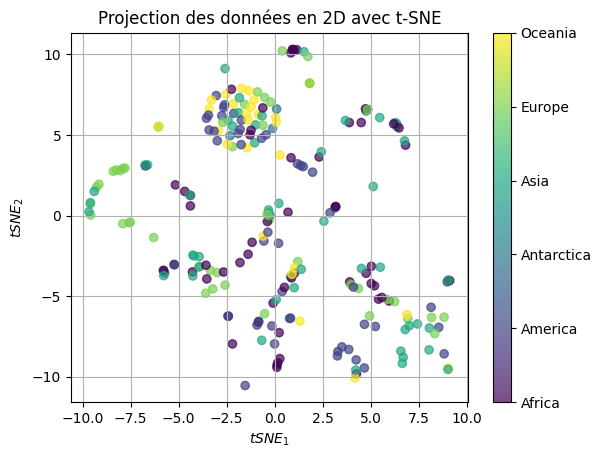

In [25]:
TSNE2D_plot(R, labels_row, labels_columns)

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import LabelEncoder

def TSNE_3D_plot(R, labels_row, labels_columns):
    # Centrer et réduire la matrice R
    X = centre_red(R)
    
    # Appliquer t-SNE pour une réduction en 3 dimensions
    tsne = TSNE(n_components=3, random_state=42)
    Y_tsne = tsne.fit_transform(X)
    
    # Encoder les labels en numéros si ce sont des catégories textuelles
    label_encoder = LabelEncoder()
    labels_encoded = label_encoder.fit_transform(labels_columns)
    
    # Tracé en 3D des données projetées
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(Y_tsne[:, 0], Y_tsne[:, 1], Y_tsne[:, 2], c=labels_encoded, cmap='viridis', alpha=0.7)
    
    # Annoter le graphique
    ax.set_xlabel('$t-SNE_1$')
    ax.set_ylabel('$t-SNE_2$')
    ax.set_zlabel('$t-SNE_3$')
    ax.set_title('Projection des données en 3D avec t-SNE')
    
    # Ajouter une barre de couleurs
    cbar = plt.colorbar(scatter, ax=ax, shrink=0.5)
    cbar.set_ticks(np.arange(len(label_encoder.classes_)))
    cbar.set_ticklabels(label_encoder.classes_)
    
    plt.show()

# Utilisation de la fonction
# TSNE_3D_plot(R, labels_row)


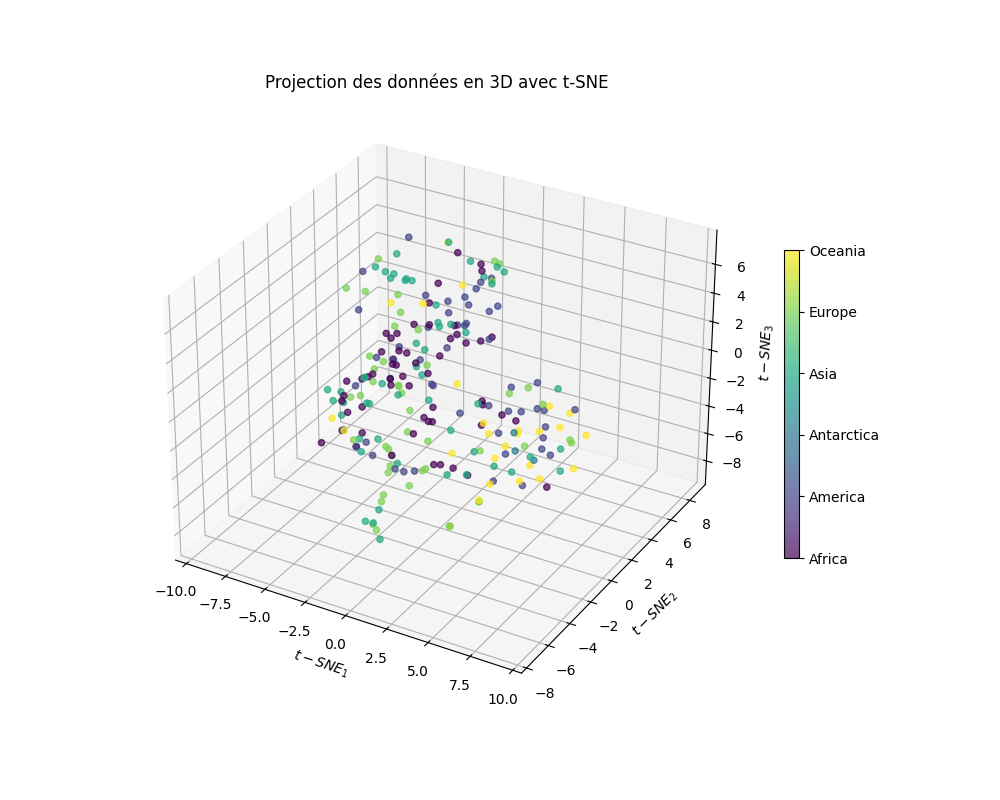

In [30]:
%matplotlib widget
TSNE_3D_plot(R, labels_row, labels_columns)